In [347]:
import bayes3d as b
import bayes3d.transforms_3d as t3d
import numpy as np 
import jax.numpy as jnp
import matplotlib.pyplot as plt
import jax
from jax.debug import print as jprint
import time
import PIL.Image
from math import sqrt
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
from IPython.display import HTML
import plotly.graph_objects as go
%matplotlib inline 


In [2]:
def display_video(frames, framerate=30):
    if type(frames[0]) == PIL.Image.Image:
      frames = [np.array(frames[i]) for i in range(len(depths))]
    height, width, _ = frames[0].shape
    dpi = 70
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
    fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
    matplotlib.use(orig_backend)  # Switch back to the original backend.
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
      im.set_data(frame)
      return [im]
    interval = 1000/framerate
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=interval, blit=True, repeat=False)
    return HTML(anim.to_html5_video())

In [3]:
intrinsics = b.Intrinsics(
    height=360,
    width=480,
    fx=180*sqrt(3), fy=180*sqrt(3),
    cx=240.0, cy=180.0,
    near=0.1, far=100.0
)
# intrinsics = b.Intrinsics(
#     height=300,
#     width=300,
#     fx=200.0, fy=200.0,
#     cx=150.0, cy=150.0,
#     near=0.001, far=6.0
# )

In [4]:
b.setup_renderer(intrinsics)
# b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=0.5)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (480, 384, 1024)


In [5]:
b.RENDERER.add_mesh_from_file("assets/cube.obj",mesh_name="cube_0", scaling_factor=[0.5,0.5,0.5])
b.RENDERER.add_mesh_from_file("assets/plane.obj",mesh_name="occluder", scaling_factor=[0.0667,0.0667,0.0667])

In [389]:
loaded_poses = np.load('scenario_test.npz')

In [390]:
occ_pose = loaded_poses['occ']
occ_pose[1:3] *= -1
occ_pose = jnp.array(occ_pose)

loaded_box_poses = loaded_poses['box']
gt_poses = []
occ_poses = []
for i in range(loaded_box_poses.shape[0]):
    pose = loaded_box_poses[i,...]
    pose[1:3] *= -1 # convert to CV2 convention (bayes3d currently assumes input is in cv2 coordinate frame)
    gt_poses.append(jnp.array(pose))
    occ_poses.append(occ_pose)
gt_poses = jnp.stack(gt_poses)
occ_poses = jnp.stack(occ_poses)

total_gt_poses = jnp.stack([gt_poses, occ_poses])

# cv2 convention of cam pose
cam_pose = loaded_poses['cam_pose']
world2cam = np.linalg.inv(cam_pose)
world2cam[1:3] *= -1
world2cam = jnp.array(world2cam)
cam_pose = jnp.linalg.inv(world2cam) 

In [391]:
# gt_images = jax.vmap(b.RENDERER.render_single_object, in_axes=(0, None))(gt_poses, jnp.int32(0))
gt_images = b.RENDERER.render_multiobject_parallel(total_gt_poses, [0,1])

# gt_images = jnp.stack([b.RENDERER.render_multiobject(
#     jnp.array([gt_poses[i], occ_pose]),
#     [0, 1]
# ) for i in range(gt_poses.shape[0])])



In [9]:
depths = [b.viz.get_depth_image(gt_images[i,:,:,2]) for i in range(gt_images.shape[0])]


In [10]:
display_video(depths)

In [392]:
translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 5, 5, 5)


dx, dy, dz = 2, 2, 2
gridding = [
    b.make_translation_grid_enumeration(
        -dx, -dy, -dz, dx, dy, dz, 5,5,5
    ),
    b.make_translation_grid_enumeration(
        -dx/2.0, -dy/2, -dz/2, dx/2, dy/2, dz/2, 5,5,5
    ),
    b.make_translation_grid_enumeration(
        -dx/10.0, -dy/10, -dz/10, dx/10, dy/10, dz/10, 5,5,5
    )
]



key = jax.random.PRNGKey(314)
rotation_deltas = jax.vmap(lambda key: b.distributions.gaussian_vmf(key, 0.00001, 800.0))(
    jax.random.split(key, 100)
)

In [393]:
pose_estimate = gt_poses[0]
occ_poses_trans = jnp.stack([occ_pose for _ in range(translation_deltas.shape[0])])
occ_poses_rot = jnp.stack([occ_pose for _ in range(rotation_deltas.shape[0])])

In [13]:
def physics_prior_v1(pose_estimate, prev_pose, prev_prev_pose, bbox_dims, camera_pose, world2cam):
    """
    Score the physics of the simulation outside of a PPL, this will
    score physics estimates independent of what we see (3DP3 likelihood)

    Version 1:

    ASSUMPTIONS:
    A1 - Single object
    A2 - Change in position, no change in orientation 
    A3 - No Friction
    A4 - No Restitution/Damping (no bouncing)
    A5 - No Collision between objects (Except single object and Floor)
    A6 - No Mass information
    A7 - No Acceleration in X-Y-Z direction
    A8 - Above line implies no Gravitational acceleration
    A9 - Centre of bbox is centre of of object's local frame
    A10 - bbox_dims are aligned with the world axes

    IMPLEMENTATION:
    I1 - Simple X-Y-Z translation integration from T-1 & T-2 (0 accleration in X-Y-Z directions)
    I2 - Switch off Y-translation if bottom of object hits the floor (assume floor_y = 0) - collision between floor and single object
    I3 - Multivariate Gaussian Noise Model to get the score

    INPUTS:
    pose_estimate: pose to score on at time = T (during the current gridding process)
    prev_pose: inferred pose at time = T-1
    prev_prev_pose: inferred pose at time = T-2
    bbox_dims: bounding box dimensions of single object
    camera_pose: cam2world affine transformation
    world2cam: world to camera coordinate transformation
    """

    # Assuming all poses are in camera frame

    # # kill switch: check if poses are not None, if so return a score of 0
    # if pose_estimate == None or prev_pose == None or prev_prev_pose == None:
    #     return 0

    # if jnp.equal(prev_prev_pose, prev_pose):
    #     return 0

    # extract x-y-z positions
    estimate_pos = pose_estimate[:3,3]
    prev_pos = prev_pose[:3,3]
    prev_prev_pos = prev_prev_pose[:3,3]

    # find X-Y-Z velicity change
    delta_pos = prev_pos - prev_prev_pos
    vel_pos = delta_pos

    # # I2 -> Check if object is on the floor
    # # conversions to world frame
    # vel_pos_world = camera_pose[:3,:] @ jnp.concatenate([vel_pos, 1], axis = None)
    # prev_pose_world = camera_pose[:3,:] @ jnp.concatenate([prev_pos, 1], axis = None)

    # # find object's bottom in world frame
    # object_bottom = prev_pose_world[2] - 0.5*bbox_dims[2]

    # # if jnp.less_equal(object_bottom, 0.01 * bbox_dims[2]): # 1% of box dims, giving some allowance to count as contact
    # #     vel_pos_world = vel_pos_world.at[2].set(0)

    # vel_pos_world = jax.lax.cond(jnp.less_equal(object_bottom, 0.01 * bbox_dims[2]),
    #     lambda x: x.at[2].set(0),
    #     lambda x: x,
    #     vel_pos_world)


    # vel_pos = world2cam[:3,:] @ jnp.concatenate([vel_pos_world, 1], axis = None)
    
    # I1 -> Integrate X-Y-Z forward to current time step
    # Note: t_step is not needed as we are ignoring gravity 
    pred_pos = vel_pos + prev_pos

    score = jax.scipy.stats.multivariate_normal.logpdf(
        estimate_pos, pred_pos, jnp.diag(jnp.array([0.02, 0.02, 0.02]))
    )

    return score
    
physics_prior_v1_jit = jax.jit(physics_prior_v1)
physics_prior_v1_parallel_jit = jax.jit(jax.vmap(physics_prior_v1, in_axes=(0, None,  None, None, None, None)))
physics_prior_v1_parallel = jax.vmap(physics_prior_v1, in_axes=(0, None,  None, None, None, None))

In [387]:
def update_pose_estimate(running_pose_estimates, gt_image):

    old_pose_estimate, prev_pose, enable_physics = running_pose_estimates

    threedp3_weight = 1
    phyisics_weight = 3000

    proposals = jnp.einsum("ij,ajk->aik", old_pose_estimate, translation_deltas)
    rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_trans]), jnp.array([0,1]))
    threedp3_scores = threedp3_weight * b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)


    physics_scores = jax.lax.cond(jnp.logical_not(enable_physics), 
    lambda _ : jnp.zeros(threedp3_scores.shape[0]), 
    lambda _ : phyisics_weight * physics_prior_v1_parallel(proposals, old_pose_estimate, prev_pose, jnp.array([1,1,1]), cam_pose, world2cam), 
    None)

    scores = threedp3_scores + physics_scores

    # jprint("\n3dp3: {}", threedp3_scores)
    # jprint("physics: {}\n", physics_scores)


    jprint("\n3dp3 min, max, diff: {}, {}, {}", jnp.min(threedp3_scores), jnp.max(threedp3_scores), jnp.max(threedp3_scores) - jnp.min(threedp3_scores))
    jprint("physics min, max, diff: {}, {}, {}\n", jnp.min(physics_scores), jnp.max(physics_scores), jnp.max(physics_scores) - jnp.min(physics_scores))
    jprint("{}", jnp.argmax(scores))
    jprint("{}", threedp3_scores.shape)
    jprint("{}", physics_scores.shape)
    # jprint("Chosen 3dp3, physics: {}, {}, {}\n", threedp3_scores[jnp.argmax(scores)], physics_scores[jnp.argmax(scores)])

    pose_estimate = proposals[jnp.argmax(scores)]

    # proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    # rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_rot]), jnp.array([0,1]))
    # weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
    # pose_estimate = proposals[jnp.argmax(weights_new)]

    enable_physics = True

    return [pose_estimate, old_pose_estimate, enable_physics], pose_estimate

def update_pose_estimate_c2f(pose_estimate, gt_image):
    for translation_deltas in gridding:
        proposals = jnp.einsum("ij,ajk->aik", pose_estimate, translation_deltas)
        rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_trans]), jnp.array([0,1]))
        weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
        pose_estimate = proposals[jnp.argmax(weights_new)]

    proposals = jnp.einsum("ij,ajk->aik", pose_estimate, rotation_deltas)
    rendered_images = b.RENDERER.render_multiobject_parallel(jnp.stack([proposals, occ_poses_rot]), jnp.array([0,1]))
    weights_new = b.threedp3_likelihood_parallel(gt_image, rendered_images, 0.05, 0.1, 10**3, 3)
    pose_estimate = proposals[jnp.argmax(weights_new)]
    return pose_estimate, pose_estimate

In [394]:
# inference_program = jax.jit(lambda p,x: jax.lax.scan(update_pose_estimate, p,x)[1])
inference_program = jax.jit(lambda p,x: jax.lax.scan(update_pose_estimate, [p,p,False],x)[1])

start = time.time()
pose_estimates_over_time = inference_program(gt_poses[0], gt_images)
end = time.time()
print ("Time elapsed:", end - start)
print ("FPS:", gt_poses.shape[0] / (end - start))


3dp3 min, max, diff: -1421635.75, -1411568.25, 10067.5
physics min, max, diff: 0.0, 0.0, 0.0

62
(array(125, dtype=int32),)
(array(125, dtype=int32),)

3dp3 min, max, diff: -1422490.0, -1411960.5, 10529.5
physics min, max, diff: 333.6524963378906, 9333.6572265625, 9000.0048828125

62
(array(125, dtype=int32),)
(array(125, dtype=int32),)

3dp3 min, max, diff: -1423253.75, -1412044.5, 11209.25
physics min, max, diff: 333.6524963378906, 9333.6572265625, 9000.0048828125

67
(array(125, dtype=int32),)
(array(125, dtype=int32),)

3dp3 min, max, diff: -1422851.625, -1411928.875, 10922.75
physics min, max, diff: -3416.34619140625, 9333.6572265625, 12750.00390625

67
(array(125, dtype=int32),)
(array(125, dtype=int32),)

3dp3 min, max, diff: -1422442.5, -1412340.0, 10102.5
physics min, max, diff: -3416.34619140625, 9333.6572265625, 12750.00390625

67
(array(125, dtype=int32),)
(array(125, dtype=int32),)

3dp3 min, max, diff: -1422010.375, -1412358.5, 9651.875
physics min, max, diff: -3416.3461

In [395]:
viz_images = []
max_depth = 10.0

pose_estimates = jnp.stack([pose_estimates_over_time, occ_poses])

rerendered_images = b.RENDERER.render_multiobject_parallel(pose_estimates_over_time[None, ...], jnp.array([0]))
# rerendered_images = b.RENDERER.render_multiobject_parallel(pose_estimates, jnp.array([0,1]))

viz_images = [
    b.viz.multi_panel(
        [b.viz.get_depth_image(d[:,:,2]), b.viz.get_depth_image(r[:,:,2])],
        ["Ground Truth", "Inferred Reconstruction"],
    )
    for (r, d) in zip(rerendered_images, gt_images)
]
display_video(viz_images)

In [127]:
### DUMMY VALUES #########

translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 10, 10, 10)

# MANUALLY SPECIFY THESE
prev_prev_pose = jnp.array([[1., 0., 0., -0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])
prev_pose = jnp.array([[1., 0., 0., -0.0],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])

best_pose = jnp.array([[1., 0., 0., 0.1],
                        [0., 1., 0., 0.],
                        [0., 0., 1., 0.],
                        [0., 0., 0., 1.]])


proposals = jnp.einsum("ij,ajk->aik", prev_pose, translation_deltas)
weights = physics_prior_v1_parallel(proposals, prev_pose, prev_prev_pose, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals, prev_pose, prev_prev_pose,weights, best_pose)

In [382]:
def plot_physics_posterior(proposals, pp, ppp, weights, best_pose = None):
    xs = np.asarray(proposals[:,0,3], dtype=float32)
    ys = np.asarray(proposals[:,1,3], dtype=float32)
    zs = np.asarray(proposals[:,2,3], dtype=float32)

    prev = np.asarray(pp[:3,3])
    prev_prev = np.asarray(ppp[:3,3])    

    anns = [dict(
        showarrow=False,
        x=prev_prev[0],
        y=prev_prev[1],
        z=prev_prev[2],
        text="T-2",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    ),
    dict(
        showarrow=False,
        x=prev[0],
        y=prev[1],
        z=prev[2],
        text="T-1",
        xanchor="left",
        xshift=5,
        opacity=0.7,
        font=dict(
            size=9  # Adjust the font size of the annotation
        )
    )]

    pts = [go.Scatter3d(x=[prev_prev[0]],
                y=[prev_prev[1]],
                z=[prev_prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            ),
    go.Scatter3d(x=[prev[0]],
                y=[prev[1]],
                z=[prev[2]],
                mode='markers',
                marker=dict(
                color='black',  # Specify the color values for each data point here
                size=2,
                symbol ='x'
                ),
            )]


    if best_pose != None:
        best = np.asarray(best_pose[:3,3])
        anns.append(dict(
                    showarrow=False,
                    x=best[0],
                    y=best[1],
                    z=best[2],
                    text="T-0 Best",
                    xanchor="left",
                    xshift=5,
                    opacity=0.7,
                    font=dict(
                        size=9  # Adjust the font size of the annotation
                    )
                ))
        pts.append( go.Scatter3d(x=[best[0]],
                    y=[best[1]],
                    z=[best[2]],
                    mode='markers',
                    marker=dict(
                    color='black',  # Specify the color values for each data point here
                    size=2,
                    symbol ='x'
                    ),
                ))

    fig = go.Figure(data=go.Volume(
        x=xs, y=ys, z=zs,
        value=np.asarray(weights),
        isomin=float(jnp.min(weights)),
        isomax=float(jnp.max(weights)),
        opacity=0.1,
        surface_count=25,
        ))
    fig.update_layout(title = 'Physics Posterior (Translation)',
                        scene_xaxis_showticklabels=True,
                    scene_yaxis_showticklabels=True,
                    scene_zaxis_showticklabels=True,
                    scene=dict(
            annotations=anns
        )
    )
    fig.add_traces(pts)

    fig.show()


In [423]:
ppp = jnp.around(cam_pose @ pose_estimates_over_time[16], 4)
pp = jnp.around(cam_pose @ pose_estimates_over_time[17], 4)
translation_deltas = b.make_translation_grid_enumeration(-0.2, -0.2, -0.2, 0.2, 0.2, 0.2, 10, 10, 10)
proposals1 = jnp.einsum("ij,ajk->aik", pp, translation_deltas)
weights1 = physics_prior_v1_parallel(proposals1, pp, ppp, jnp.array([1,1,1]), cam_pose, world2cam)
plot_physics_posterior(proposals1, pp, ppp,weights1)


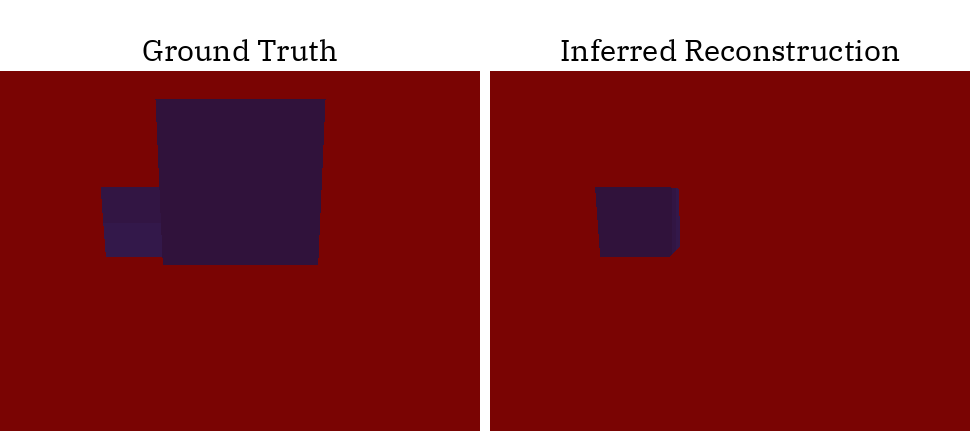

In [421]:
viz_images[16]

In [419]:
pose_estimates_over_time[15]

Array([[ 1.0000000e+00,  1.7313140e-10, -1.8608167e-05, -1.4833474e+00],
       [-1.8325498e-05, -1.7362984e-01, -9.8481101e-01, -4.9249962e-01],
       [-3.2311036e-06,  9.8481101e-01, -1.7362984e-01,  4.9131575e+00],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)